# Exploring Co-Morbidities

## Read data files

In [1]:
import os
import pandas as pd


datamatrixDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240531/data/data_matrix.csv')
icdDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240119/additional_data/2023-03-20-blood-pos-ICDs.csv')

/tmp/ipykernel_639181/3040462972.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  icdDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240119/additional_data/2023-03-20-blood-pos-ICDs.csv')


In [2]:
icdDf.shape, datamatrixDf.shape

((456648, 7), (116754, 194))

## Filter patients from the cohort

In [3]:
filteredIcdDf = icdDf.merge(
    datamatrixDf[['person_id', 'visit_occurrence_id']].drop_duplicates(),
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
    )

In [4]:
filteredIcdDf.shape

(62563, 9)

## Explore

In [5]:
datamatrixDf.person_id.drop_duplicates().shape[0]

3951

In [6]:
filteredIcdDf.PATIENT_ID.drop_duplicates().shape[0]

1743

In [7]:
filteredIcdDf.shape[0]

62563

In [8]:
filteredIcdDf.shape[0]/filteredIcdDf.PATIENT_ID.drop_duplicates().shape[0]

35.8938611589214

In [9]:
filteredIcdDf

,EPISODE_ID,PATIENT_ID,AUSTRALIAN_MODIFICATION,PREFIX,ICD_DESCRIPTION,RANK,ICD10CODE,person_id,visit_occurrence_id
0,17101855,2182523,Z029,P,"Examination for administrative purposes, unspe...",1,NaN,2182523,17101855
1,17080890,111862,C9100,P,"Acute lymphoblastic leukaemia [ALL], without m...",1,C91.0,111862,17080890
2,17080890,111862,M98353,P,Precursor cell lymphoblastic leukaemia NOS,2,NaN,111862,17080890
3,17079063,2402765,Z029,P,"Examination for administrative purposes, unspe...",1,NaN,2402765,17079063
4,17042321,2480594,R040,C,Epistaxis,6,NaN,2480594,17042321
...,...,...,...,...,...,...,...,...,...
62558,133225,2152832,C9101,P,"Acute lymphoblastic leukaemia [ALL], in remission",1,NaN,2152832,133225
62559,133225,2152832,M98353,P,Precursor cell lymphoblastic leukaemia NOS,2,NaN,2152832,133225
62560,113016,2152832,Z511,P,Pharmacotherapy session for neoplasm,1,NaN,2152832,113016
62561,113016,2152832,C9100,P,"Acute lymphoblastic leukaemia [ALL], without m...",2,NaN,2152832,113016


### Word Cloud

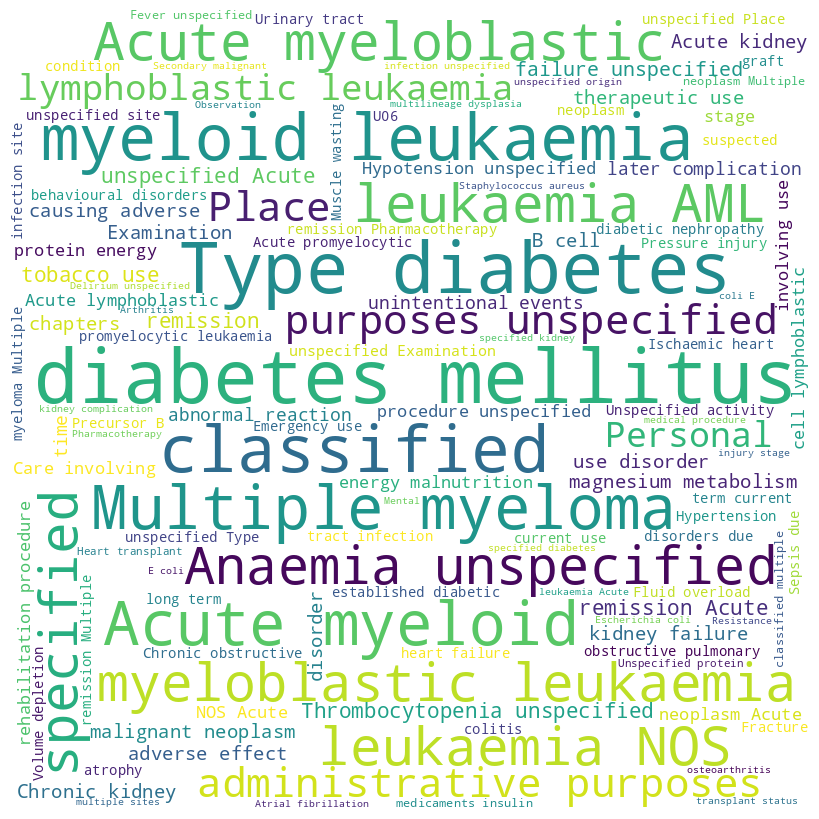

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

stopwords = set(STOPWORDS)
additionalStopwords = {'facility', 'service', 'area', 'session', 'cause', 'occurrence', 'faculty', 'diseases', 'disease', 'health', 'without', 'elsewhere', 'history', 'mention'}
stopwords = stopwords.union(additionalStopwords)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(filteredIcdDf.ICD_DESCRIPTION))

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Counts

#### Episode level

In [11]:
episodeCountsDf = filteredIcdDf[['EPISODE_ID', 'PATIENT_ID', 'ICD_DESCRIPTION']]\
    .groupby(['EPISODE_ID', 'PATIENT_ID']).agg(['count'])
episodeCountsDf.columns = episodeCountsDf.columns.droplevel(0)
episodeCountsDf = episodeCountsDf.reset_index()
episodeCountsDf

,EPISODE_ID,PATIENT_ID,count
0,113016,2152832,3
1,133225,2152832,2
2,145028,1548773,6
3,178895,2081586,2
4,189928,2152832,3
...,...,...,...
9049,17020273,2225820,4
9050,17042321,2480594,6
9051,17079063,2402765,1
9052,17080890,111862,2


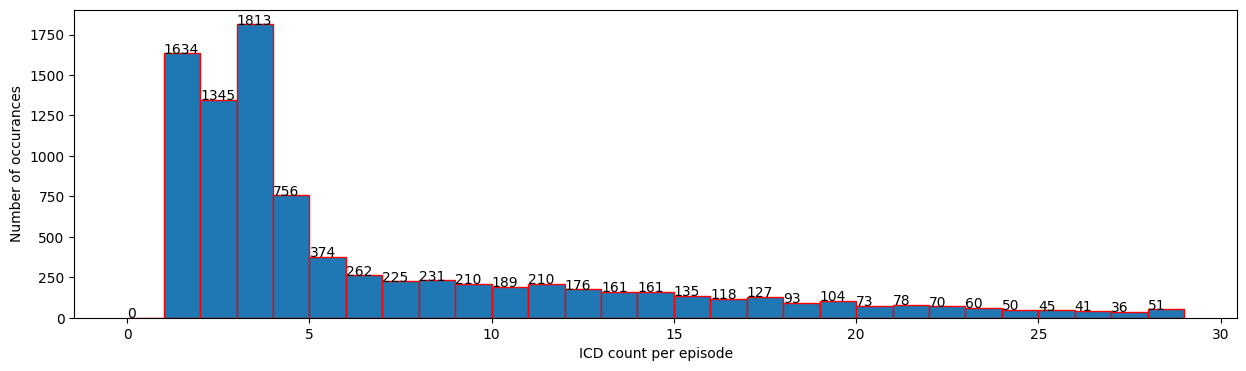

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# plot the histogram of the data
bins = np.arange(0,30,1)
fig = plt.figure(figsize=(15,4))
ax = plt.gca()
counts, _, patches = ax.hist(episodeCountsDf['count'], bins=bins, edgecolor='r')
for count, patch in zip(counts,patches):
    ax.annotate(str(int(count)), xy=(patch.get_x(), patch.get_height()))
plt.xlabel('ICD count per episode')
plt.ylabel('Number of occurances')
plt.show()


#### Person Level

In [13]:
personCountsDf = filteredIcdDf[['PATIENT_ID', 'ICD_DESCRIPTION']]\
    .groupby(['PATIENT_ID']).agg(['count'])
personCountsDf.columns = personCountsDf.columns.droplevel(0)
personCountsDf = personCountsDf.reset_index()
personCountsDf

,PATIENT_ID,count
0,50056,19
1,56749,30
2,57756,25
3,62567,12
4,77432,8
...,...,...
1738,2513125,25
1739,2514472,31
1740,2515515,175
1741,2522101,12


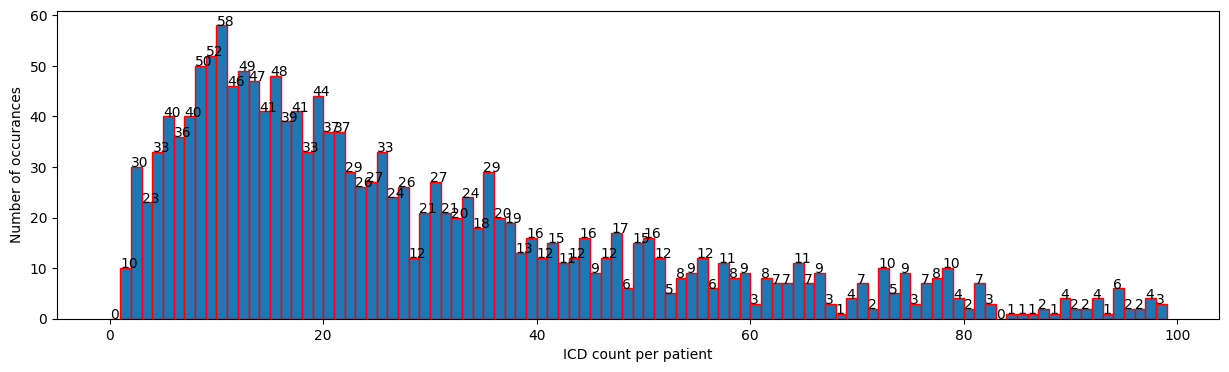

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# plot the histogram of the data
bins = np.arange(0,100,1)
fig = plt.figure(figsize=(15,4))
ax = plt.gca()
counts, _, patches = ax.hist(personCountsDf['count'], bins=bins, edgecolor='r')
for count, patch in zip(counts,patches):
    ax.annotate(str(int(count)), xy=(patch.get_x(), patch.get_height()))
plt.xlabel('ICD count per patient')
plt.ylabel('Number of occurances')
plt.show()


### Top co-morbidities

In [15]:
topComorbiditiesDf = filteredIcdDf[['ICD_DESCRIPTION', 'PATIENT_ID']].groupby(['ICD_DESCRIPTION']).agg(['count'])
topComorbiditiesDf.columns = topComorbiditiesDf.columns.droplevel(0)
topComorbiditiesDf = topComorbiditiesDf.reset_index()
pd.set_option('display.max_colwidth', None)
topComorbiditiesDf.sort_values(by=['count'], ascending=False)[:20]

,ICD_DESCRIPTION,count
2421,Pharmacotherapy session for neoplasm,1681
864,"Examination for administrative purposes, unspecified",1354
1201,Hypertension,1311
2450,"Place of occurrence, health service area, this facility",1209
106,Acute myeloid leukaemia NOS,1188
200,"Anaemia, unspecified",1152
2973,"Thrombocytopenia, unspecified",1010
1675,Multiple myeloma,956
105,"Acute myeloblastic leukaemia [AML], without mention of remission",933
1677,"Multiple myeloma, without mention of remission",901


In [16]:
import os
from pathlib import Path

saveDf = filteredIcdDf[['ICD_DESCRIPTION', 'AUSTRALIAN_MODIFICATION', 'PATIENT_ID']].groupby(['AUSTRALIAN_MODIFICATION', 'ICD_DESCRIPTION']).agg('count').reset_index().rename(columns={'PATIENT_ID': 'Count'})
saveDf = saveDf.sort_values(by=['Count'], ascending=False)
saveDf.to_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240531', 'etc', 'comorbidities.csv'), index=False)
saveDf

,AUSTRALIAN_MODIFICATION,ICD_DESCRIPTION,Count
3130,Z511,Pharmacotherapy session for neoplasm,1681
3054,Z029,"Examination for administrative purposes, unspecified",1354
2773,U823,Hypertension,1311
3037,Y9224,"Place of occurrence, health service area, this facility",1209
1920,M98613,Acute myeloid leukaemia NOS,1188
...,...,...,...
1460,L851,Acquired keratosis [keratoderma] palmaris et plantaris,1
1464,L8903,"Pressure injury, stage I, upper back",1
1470,L891,Stage II decubitus ulcer and pressure area,1
1444,L538,Other specified erythematous conditions,1


## Counts by ICD category groups

In [17]:
import os
import pandas as pd
from pathlib import Path


icdLookup = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240531', 'etc', 'icd_10', 'icd102019syst_groups.txt'), sep=';', header=None)
icdLookup.columns = ['ICD_CATEGORY_START', 'ICD_CATEGORY_END', 'ICD_CHAPTER', 'DESCRIPTION']
icdLookup['ICD_CATEGORY_START_NUMBER'] = icdLookup.ICD_CATEGORY_START.str[1:]
icdLookup['ICD_CATEGORY_START_LETTER'] = icdLookup.ICD_CATEGORY_START.str[:1]
icdLookup['ICD_CATEGORY_END_NUMBER'] = icdLookup.ICD_CATEGORY_END.str[1:]
icdLookup['ICD_CATEGORY_END_LETTER'] = icdLookup.ICD_CATEGORY_END.str[:1]
icdLookup

,ICD_CATEGORY_START,ICD_CATEGORY_END,ICD_CHAPTER,DESCRIPTION,ICD_CATEGORY_START_NUMBER,ICD_CATEGORY_START_LETTER,ICD_CATEGORY_END_NUMBER,ICD_CATEGORY_END_LETTER
0,A00,A09,1,Intestinal infectious diseases,00,A,09,A
1,A15,A19,1,Tuberculosis,15,A,19,A
2,A20,A28,1,Certain zoonotic bacterial diseases,20,A,28,A
3,A30,A49,1,Other bacterial diseases,30,A,49,A
4,A50,A64,1,Infections with a predominantly sexual mode of transmission,50,A,64,A
...,...,...,...,...,...,...,...,...
258,Z55,Z65,21,Persons with potential health hazards related to socioeconomic and psychosocial circumstances,55,Z,65,Z
259,Z70,Z76,21,Persons encountering health services in other circumstances,70,Z,76,Z
260,Z80,Z99,21,Persons with potential health hazards related to family and personal history and certain conditions influencing health status,80,Z,99,Z
261,U00,U49,22,Provisional assignment of new diseases of uncertain etiology or emergency use,00,U,49,U


In [18]:
filteredIcdDf['ICD_CATEGORY'] = filteredIcdDf.AUSTRALIAN_MODIFICATION.str[:3]
filteredIcdDf['ICD_CATEGORY_NUMBER'] = filteredIcdDf.ICD_CATEGORY.str[1:]
filteredIcdDf['ICD_CATEGORY_LETTER'] = filteredIcdDf.ICD_CATEGORY.str[:1]

mergedDf = filteredIcdDf.merge(
    icdLookup,
    how='left',
    left_on=['ICD_CATEGORY_LETTER', 'ICD_CATEGORY_LETTER'],
    right_on=['ICD_CATEGORY_START_LETTER', 'ICD_CATEGORY_END_LETTER']
)

mergedDf = mergedDf[(mergedDf.ICD_CATEGORY_NUMBER >= mergedDf.ICD_CATEGORY_START_NUMBER) & (mergedDf.ICD_CATEGORY_NUMBER <= mergedDf.ICD_CATEGORY_END_NUMBER)]
mergedDf[['ICD_CATEGORY', 'ICD_CHAPTER', 'DESCRIPTION', 'ICD_CATEGORY_START', 'ICD_CATEGORY_END']]

groupedDf = mergedDf[['ICD_CATEGORY_START', 'ICD_CATEGORY_END', 'ICD_CHAPTER', 'DESCRIPTION', 'PATIENT_ID']].drop_duplicates().groupby(by=['ICD_CATEGORY_START', 'ICD_CATEGORY_END', 'ICD_CHAPTER', 'DESCRIPTION']).agg(['count'])
groupedDf.columns = groupedDf.columns.levels[1]
groupedDf = groupedDf.reset_index()
groupedDf['PERCENTAGE'] = round(groupedDf['count']/filteredIcdDf.PATIENT_ID.drop_duplicates().shape[0]*100, 2)
groupedDf = groupedDf.sort_values(by=['count'], ascending=False)
groupedDf[:20]

,ICD_CATEGORY_START,ICD_CATEGORY_END,ICD_CHAPTER,DESCRIPTION,count,PERCENTAGE
212,Y90,Y98,20,Supplementary factors related to causes of morbidity and mortality classified elsewhere,1084,62.19
46,E70,E90,4,Metabolic disorders,969,55.59
188,U82,U85,22,Resistance to antimicrobial and antineoplastic drugs,897,51.46
3,A30,A49,1,Other bacterial diseases,849,48.71
216,Z40,Z54,21,Persons encountering health services for specific procedures and health care,807,46.30
219,Z80,Z99,21,Persons with potential health hazards related to family and personal history and certain conditions influencing health status,798,45.78
213,Z00,Z13,21,Persons encountering health services for examination and investigation,682,39.13
161,R50,R69,18,General symptoms and signs,664,38.10
137,N17,N19,14,Renal failure,650,37.29
15,B95,B98,1,"Bacterial, viral and other infectious agents",599,34.37


In [19]:
groupedDf.shape

(220, 6)

In [20]:
import os
from pathlib import Path


groupedDf.to_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240531', 'etc', 'comorbidities_icd_groups.csv'), index=False)
groupedDf

,ICD_CATEGORY_START,ICD_CATEGORY_END,ICD_CHAPTER,DESCRIPTION,count,PERCENTAGE
212,Y90,Y98,20,Supplementary factors related to causes of morbidity and mortality classified elsewhere,1084,62.19
46,E70,E90,4,Metabolic disorders,969,55.59
188,U82,U85,22,Resistance to antimicrobial and antineoplastic drugs,897,51.46
3,A30,A49,1,Other bacterial diseases,849,48.71
216,Z40,Z54,21,Persons encountering health services for specific procedures and health care,807,46.30
...,...,...,...,...,...,...
146,O10,O16,15,"Oedema, proteinuria and hypertensive disorders in pregnancy, childbirth and the puerperium",1,0.06
151,Q50,Q56,17,Congenital malformations of genital organs,1,0.06
20,C40,C41,2,Malignant neoplasms of bone and articular cartilage,1,0.06
12,B65,B83,1,Helminthiases,1,0.06


## Charlson Comorbidity Index

In [24]:
filteredIcdDf

,EPISODE_ID,PATIENT_ID,AUSTRALIAN_MODIFICATION,PREFIX,ICD_DESCRIPTION,RANK,ICD10CODE,person_id,visit_occurrence_id,ICD_CATEGORY,ICD_CATEGORY_NUMBER,ICD_CATEGORY_LETTER
0,17101855,2182523,Z029,P,"Examination for administrative purposes, unspecified",1,NaN,2182523,17101855,Z02,02,Z
1,17080890,111862,C9100,P,"Acute lymphoblastic leukaemia [ALL], without mention of remission",1,C91.0,111862,17080890,C91,91,C
2,17080890,111862,M98353,P,Precursor cell lymphoblastic leukaemia NOS,2,NaN,111862,17080890,M98,98,M
3,17079063,2402765,Z029,P,"Examination for administrative purposes, unspecified",1,NaN,2402765,17079063,Z02,02,Z
4,17042321,2480594,R040,C,Epistaxis,6,NaN,2480594,17042321,R04,04,R
...,...,...,...,...,...,...,...,...,...,...,...,...
62558,133225,2152832,C9101,P,"Acute lymphoblastic leukaemia [ALL], in remission",1,NaN,2152832,133225,C91,91,C
62559,133225,2152832,M98353,P,Precursor cell lymphoblastic leukaemia NOS,2,NaN,2152832,133225,M98,98,M
62560,113016,2152832,Z511,P,Pharmacotherapy session for neoplasm,1,NaN,2152832,113016,Z51,51,Z
62561,113016,2152832,C9100,P,"Acute lymphoblastic leukaemia [ALL], without mention of remission",2,NaN,2152832,113016,C91,91,C


In [45]:
filteredIcdDf[filteredIcdDf.ICD_DESCRIPTION.str.lower().str.contains('dementia')][['AUSTRALIAN_MODIFICATION', 'ICD_DESCRIPTION']].value_counts()

AUSTRALIAN_MODIFICATION  ICD_DESCRIPTION                                                 
F050                     Delirium not superimposed on dementia, so described                 70
U791                     Dementia (including in Alzheimer's disease)                         44
F051                     Delirium superimposed on dementia                                   41
F009                     Dementia in Alzheimer's disease, unspecified (G30.9+)               18
F019                     Vascular dementia, unspecified                                      12
F03                      Unspecified dementia                                                 5
F002                     Dementia in Alzheimer's disease, atypical or mixed type (G30.8+)     4
F023                     Dementia in Parkinson's disease (G20+)                               3
F028                     Dementia in other specified diseases classified elsewhere            3
F020                     Dementia in Pick's di

In [28]:
filteredIcdDf[filteredIcdDf.AUSTRALIAN_MODIFICATION.str.startswith('I2')][['AUSTRALIAN_MODIFICATION', 'ICD_DESCRIPTION']].value_counts()

AUSTRALIAN_MODIFICATION  ICD_DESCRIPTION                                                               
I214                     Acute subendocardial myocardial infarction                                        87
I2511                    Atherosclerotic heart disease, of native coronary artery                          82
I269                     Pulmonary embolism without mention of acute cor pulmonale                         79
I272                     Other secondary pulmonary hypertension                                            44
I255                     Ischaemic cardiomyopathy                                                          33
I210                     Acute transmural myocardial infarction of anterior wall                           12
I270                     Primary pulmonary hypertension                                                     7
I240                     Coronary thrombosis not resulting in myocardial infarction                         7
I259            

In [31]:
filteredIcdDf[filteredIcdDf.AUSTRALIAN_MODIFICATION.str.startswith('I500')][['AUSTRALIAN_MODIFICATION', 'ICD_DESCRIPTION']].value_counts()

AUSTRALIAN_MODIFICATION  ICD_DESCRIPTION         
I500                     Congestive heart failure    185
dtype: int64

In [32]:
round(filteredIcdDf[filteredIcdDf.AUSTRALIAN_MODIFICATION.str.startswith('I500')].PATIENT_ID.unique().shape[0]/filteredIcdDf.PATIENT_ID.unique().shape[0] * 100, 2)

8.03